# without global pool
# batch with larger learning rate is much more stable
# with only 2 actions: without fire and stop!

In [1]:
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

# from torchvision import transforms

%matplotlib inline

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
env = gym.make("Pong-v0")

[2018-01-08 15:06:49,283] Making new env: Pong-v0


In [4]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [5]:
downsample = 2
output_size = 160//downsample
batch_size = 10 # and learning rate become larger
learning_rate = 1.e-4 * batch_size

In [8]:
def preprocess(frame):
    '''from karpathy.'''
    I = frame
    I = I[35:195] # crop
    I = I[::downsample,::downsample,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    tensor = torch.from_numpy(I).float()
    return tensor.unsqueeze(0).unsqueeze(0) #BCHW

def clip_grads(net, low=-10, high=10):
    """Gradient clipping to the range [low, high]."""
    parameters = [param for param in net.parameters()
                  if param.grad is not None]
    for p in parameters:
        p.grad.data.clamp_(low, high)
        
if torch.cuda.is_available():
    def to_var(x, requires_grad=False, gpu=None):
        x = x.cuda(gpu)
        return Variable(x, requires_grad=requires_grad)
else:
    def to_var(x, requires_grad=False, vgpu=None):
        return Variable(x, requires_grad=requires_grad)

In [9]:
class Net(nn.Module):
    '''very similar to Nature DQN.'''
    def __init__(self, action_n, input_shape=(1,80,80)):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(input_shape[0],16,kernel_size=8, stride=2),nn.ReLU(),
                                  nn.Conv2d(16,32,kernel_size=4, stride=2),nn.ReLU())
        flatten_size = self._get_flatten_size(input_shape)
        self.fc = nn.Linear(flatten_size, action_n)
    
    def _get_flatten_size(self, shape):
        x = Variable(torch.rand(1, *shape))
        output_feat = self.conv(x)
        n_size = output_feat.view(-1).size(0)
        return n_size
        
    def forward(self, x):
        feat = self.conv(x)
        logit = self.fc(feat.view(feat.size(0),-1))
        return logit

In [10]:
class PolicyGradient:
    
    def __init__(self, model, gamma=0.99, eps=1.e-6, running_gamma=0.99, running_start=0,
#                 episode2thresh=lambda i: 0.05+0.9*np.exp(-1. * i / 100) if i>150 else 0): # eploration will start after 150 episodes
                 episode2thresh=lambda i: 0): # without exploration
        self.model = model
        self.gamma = gamma
        self.eps = eps
        self.log_probs = []
        self.rewards = []
        self.total_rewards = []
        self.running_reward = running_start
        self.running_gamma = running_gamma
        self.episode2thresh = episode2thresh
        
    @property
    def episodes(self):
        return len(self.total_rewards)
        
    def select_action(self,obs):
        self.model.train()
        thresh=self.episode2thresh(self.episodes)
        action, log_prob = select_action(obs, self.model, thresh=thresh)
        self.log_probs.append(log_prob)
        return action
    
    def get_loss_and_clear(self):
        total_reward = sum(self.rewards)
        self.total_rewards.append(total_reward)
        self.running_reward = self.running_gamma*self.running_reward+(1-self.running_gamma)*total_reward
        policy_loss = get_policy_loss(self.log_probs, self.rewards, self.gamma, self.eps)
        del self.log_probs[:]
        del self.rewards[:]
        return policy_loss
    
    def take_action(self, action, env, render=False):
        obs, reward, done, info = env.step(action)
        self.rewards.append(reward)
        if render:
            env.render()
        return obs, reward, done, info
    
    def greedy_policy(self, obs):
        self.model.eval()
        state = to_var(obs)
        prob = self.model(state)
        _, action = prob.max(dim=1)
        return action.data[0]

def select_action(obs, model, thresh=0):
    state = to_var(obs)
    logits = model(state)
    probs = F.softmax(logits, dim=1)
    m = Categorical(probs)
    action = m.sample()
#     if np.random.random()>thresh:
# #         print(probs)
#         try:
#             action = m.sample()
#         except:
#             print(probs,m)
#             raise
#     else:
#         action_space = probs.size(1)
#         action = to_var(torch.from_numpy(np.random.randint(action_space,size=1)))
    return action.data[0],m.log_prob(action)
    
def get_normalized_rewards(rewards, gamma, eps):
    acc = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        acc.append(R)
    ret = to_var(torch.Tensor(acc[::-1]),requires_grad=False)
    ret = (ret - ret.mean()) / (ret.std()+eps)
#     print(ret)
    return ret

def get_policy_loss(log_probs,rewards, gamma,eps):
    log_probs_v = torch.cat(log_probs)
    rewards_v = get_normalized_rewards(rewards, gamma, eps)
    return -log_probs_v.dot(rewards_v)

In [11]:
env.action_space.n

6

In [12]:
net = Net(2, input_shape=(1,output_size,output_size))
if torch.cuda.is_available():
    net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
trainer = PolicyGradient(model=net,running_start=-21)
writer = SummaryWriter()

In [13]:
# net.load_state_dict(torch.load('tmp/Jan08_14-04-48_amax/episode700.pth'))
# saved_weights = torch.load('tmp/Jan06_23-26-49_amax/episode12500.pth')
# net.load_state_dict({k:saved_weights[k] for k in saved_weights if not k.startswith('fc')},strict=False) # load without fc

In [14]:
writer_path = list(writer.all_writers.keys())[0]
weight_join = lambda p: os.path.join(writer_path, p)

In [15]:
writer_path

'runs/Jan08_15-07-08_amax'

In [16]:
optimizer.zero_grad()

In [17]:
for episode in trange(100000):
    frame = env.reset()
    last_obs = preprocess(frame)
    curr_obs = preprocess(frame)
    total_reward = 0
    for step in range(100000): # not exceed 10000 steps
        action = trainer.select_action(obs=curr_obs-last_obs)
#         print(episode, step, action)
        frame, reward, done, _ = trainer.take_action(action+2, env, render=False) # action+1  !!!!!!!!!!!!!!!
        last_obs = curr_obs
        curr_obs = preprocess(frame)
        total_reward+=reward
        if done:
             break
    if step==100000:
        print("not enough!!!!!!!!!!!!!!!")
    policy_loss = trainer.get_loss_and_clear()
    writer.add_scalar("loss",policy_loss.data[0],episode)
    writer.add_scalar("reward",total_reward,episode)
    policy_loss.backward()
    if (episode+1)%batch_size==0:
        clip_grads(trainer.model,-10,10)
        optimizer.step()
        optimizer.zero_grad()
    running_reward = trainer.running_reward
    if episode%100==0:
        print(episode, total_reward,running_reward)
        torch.save(net.state_dict(), weight_join("episode%s.pth"%episode))
    if running_reward>1:
        break
print("Finished: %s@%s" %(trainer.running_reward,episode))

  0%|          | 1/100000 [00:03<91:35:45,  3.30s/it]

0 -21.0 -21.0


  0%|          | 101/100000 [04:02<73:51:11,  2.66s/it]

100 -20.0 -20.708588900628115


  0%|          | 201/100000 [07:53<72:52:16,  2.63s/it]

200 -21.0 -20.70454088435519


  0%|          | 301/100000 [12:19<81:06:49,  2.93s/it]

300 -19.0 -20.508750686561743


  0%|          | 401/100000 [17:09<80:33:21,  2.91s/it]

400 -21.0 -20.20810504590469


  1%|          | 501/100000 [22:22<92:28:25,  3.35s/it]

500 -21.0 -19.94068375911453


  1%|          | 601/100000 [27:51<99:59:53,  3.62s/it] 

600 -21.0 -19.65024083495405


  1%|          | 701/100000 [33:47<99:00:46,  3.59s/it]

700 -20.0 -19.68306888216018


  1%|          | 801/100000 [40:31<106:36:17,  3.87s/it]

800 -21.0 -19.75188300600021


  1%|          | 901/100000 [48:15<145:16:15,  5.28s/it]

900 -19.0 -19.672080060208142


  1%|          | 1001/100000 [57:54<164:54:46,  6.00s/it]

1000 -19.0 -19.4899207598333


  1%|          | 1101/100000 [1:08:15<178:12:37,  6.49s/it]

1100 -19.0 -19.100830771827194


  1%|          | 1201/100000 [1:20:16<196:21:50,  7.16s/it]

1200 -20.0 -18.840179986800944


  1%|▏         | 1301/100000 [1:33:16<221:34:03,  8.08s/it]

1300 -18.0 -18.681807380866847


  1%|▏         | 1401/100000 [1:45:28<189:40:27,  6.93s/it]

1400 -20.0 -18.822284903952635


  2%|▏         | 1501/100000 [1:57:59<203:50:59,  7.45s/it]

1500 -17.0 -18.442410880992767


  2%|▏         | 1601/100000 [2:10:38<204:18:28,  7.47s/it]

1600 -17.0 -18.301367318857032


  2%|▏         | 1701/100000 [2:23:06<210:28:11,  7.71s/it]

1700 -17.0 -18.084494588632232


  2%|▏         | 1801/100000 [2:35:38<212:01:15,  7.77s/it]

1800 -15.0 -18.24634876637411


  2%|▏         | 1901/100000 [2:49:00<222:34:06,  8.17s/it]

1900 -17.0 -18.043262309452285


  2%|▏         | 2001/100000 [3:03:08<240:44:30,  8.84s/it]

2000 -15.0 -17.718924272703237


  2%|▏         | 2101/100000 [3:17:17<251:41:40,  9.26s/it]

2100 -15.0 -17.43402939879295


  2%|▏         | 2201/100000 [3:32:04<252:00:03,  9.28s/it]

2200 -17.0 -17.20682381976094


  2%|▏         | 2301/100000 [3:47:29<226:44:19,  8.35s/it]

2300 -17.0 -16.95886545815224


  2%|▏         | 2401/100000 [4:02:52<251:05:55,  9.26s/it]

2400 -19.0 -17.19046056668862


  3%|▎         | 2501/100000 [4:20:34<302:34:25, 11.17s/it]

2500 -13.0 -16.810562921010074


  3%|▎         | 2601/100000 [4:38:53<294:03:40, 10.87s/it]

2600 -17.0 -16.547222201653046


  3%|▎         | 2701/100000 [4:56:10<304:44:57, 11.28s/it]

2700 -13.0 -16.49739616545698


  3%|▎         | 2801/100000 [5:12:45<287:41:03, 10.66s/it]

2800 -11.0 -16.542353949957857


  3%|▎         | 2901/100000 [5:29:47<272:43:15, 10.11s/it]

2900 -17.0 -16.673108631572354


  3%|▎         | 3001/100000 [5:46:55<288:42:37, 10.72s/it]

3000 -16.0 -16.559018389488934


  3%|▎         | 3101/100000 [6:04:16<293:41:23, 10.91s/it]

3100 -11.0 -16.34230399625107


  3%|▎         | 3201/100000 [6:21:33<270:05:16, 10.04s/it]

3200 -19.0 -16.373745923962282


  3%|▎         | 3301/100000 [6:38:33<293:04:28, 10.91s/it]

3300 -12.0 -16.559190672546528


  3%|▎         | 3401/100000 [6:55:55<269:21:14, 10.04s/it]

3400 -19.0 -16.65549258715553


  4%|▎         | 3501/100000 [7:13:40<282:22:39, 10.53s/it]

3500 -19.0 -16.503503217738526


  4%|▎         | 3601/100000 [7:32:10<285:11:20, 10.65s/it]

3600 -16.0 -16.019147512154824


  4%|▎         | 3701/100000 [7:49:13<268:46:41, 10.05s/it]

3700 -16.0 -16.37952904777173


  4%|▍         | 3801/100000 [8:06:55<275:34:05, 10.31s/it]

3800 -17.0 -16.26483689157196


  4%|▍         | 3901/100000 [8:25:07<273:12:50, 10.23s/it]

3900 -16.0 -16.038870056808825


  4%|▍         | 4001/100000 [8:42:53<297:45:38, 11.17s/it]

4000 -15.0 -15.9144966286196


  4%|▍         | 4101/100000 [9:01:22<332:53:30, 12.50s/it]

4100 -13.0 -15.694337227434358


  4%|▍         | 4201/100000 [9:18:39<290:42:01, 10.92s/it]

4200 -17.0 -15.788629882907061


  4%|▍         | 4301/100000 [9:37:13<294:57:43, 11.10s/it]

4300 -19.0 -15.602563141794112


  4%|▍         | 4401/100000 [9:54:58<308:21:36, 11.61s/it]

4400 -15.0 -15.797370527678028


  5%|▍         | 4501/100000 [10:12:44<297:25:44, 11.21s/it]

4500 -16.0 -15.923530015837422


  5%|▍         | 4601/100000 [10:30:40<288:42:34, 10.89s/it]

4600 -19.0 -15.854852868157192


  5%|▍         | 4701/100000 [10:48:30<262:42:56,  9.92s/it]

4700 -19.0 -16.3416165621205


  5%|▍         | 4801/100000 [11:06:27<282:04:51, 10.67s/it]

4800 -18.0 -16.00205876699586


  5%|▍         | 4901/100000 [11:24:03<284:54:38, 10.79s/it]

4900 -16.0 -16.317315022103855


  5%|▌         | 5001/100000 [11:41:02<249:09:02,  9.44s/it]

5000 -19.0 -16.654666472298885


  5%|▌         | 5101/100000 [11:58:57<294:24:25, 11.17s/it]

5100 -11.0 -16.01466664517825


  5%|▌         | 5201/100000 [12:16:38<291:42:24, 11.08s/it]

5200 -11.0 -15.641971428915458


  5%|▌         | 5301/100000 [12:34:37<263:32:27, 10.02s/it]

5300 -19.0 -15.465716352796099


  5%|▌         | 5401/100000 [12:52:26<313:24:36, 11.93s/it]

5400 -17.0 -15.859258009499548


  6%|▌         | 5501/100000 [13:10:56<286:04:46, 10.90s/it]

5500 -8.0 -15.784881049104728


  6%|▌         | 5601/100000 [13:28:49<272:21:29, 10.39s/it]

5600 -18.0 -15.601299081185347


  6%|▌         | 5701/100000 [13:47:12<272:46:46, 10.41s/it]

5700 -17.0 -15.697210014074487


  6%|▌         | 5801/100000 [14:05:04<262:35:31, 10.04s/it]

5800 -16.0 -15.407013673489969


  6%|▌         | 5901/100000 [14:22:27<265:25:40, 10.15s/it]

5900 -17.0 -15.801284945136613


  6%|▌         | 6001/100000 [14:40:59<285:37:35, 10.94s/it]

6000 -15.0 -15.727189507902878


  6%|▌         | 6101/100000 [14:59:07<277:43:16, 10.65s/it]

6100 -15.0 -15.910613296122609


  6%|▌         | 6201/100000 [15:18:16<301:53:14, 11.59s/it]

6200 -16.0 -15.162300056705433


  6%|▋         | 6301/100000 [15:37:01<273:07:30, 10.49s/it]

6300 -19.0 -15.256479768892905


  6%|▋         | 6401/100000 [15:55:28<259:29:02,  9.98s/it]

6400 -14.0 -15.339522556744289


  7%|▋         | 6501/100000 [16:14:04<304:15:16, 11.71s/it]

6500 -15.0 -15.243432968878396


  7%|▋         | 6601/100000 [16:32:27<268:13:41, 10.34s/it]

6600 -19.0 -15.534785344129077


  7%|▋         | 6701/100000 [16:50:37<289:46:19, 11.18s/it]

6700 -19.0 -15.668870603936822


  7%|▋         | 6801/100000 [17:09:35<289:14:47, 11.17s/it]

6800 -15.0 -15.658308787753668


  7%|▋         | 6901/100000 [17:28:04<268:35:52, 10.39s/it]

6900 -17.0 -15.319638943159644


  7%|▋         | 7001/100000 [17:47:14<267:38:59, 10.36s/it]

7000 -17.0 -15.200255463649864


  7%|▋         | 7101/100000 [18:06:05<302:23:23, 11.72s/it]

7100 -15.0 -15.512604402093048


  7%|▋         | 7201/100000 [18:25:04<290:30:04, 11.27s/it]

7200 -17.0 -15.602466514530711


  7%|▋         | 7301/100000 [18:44:12<310:33:28, 12.06s/it]

7300 -15.0 -15.788171759419821


  7%|▋         | 7401/100000 [19:04:22<345:10:25, 13.42s/it]

7400 -17.0 -15.299225900991571


  8%|▊         | 7501/100000 [19:24:20<298:51:39, 11.63s/it]

7500 -15.0 -15.383513158882813


  8%|▊         | 7601/100000 [19:44:13<309:40:39, 12.07s/it]

7600 -17.0 -15.565282050388515


  8%|▊         | 7701/100000 [20:04:39<309:21:43, 12.07s/it]

7700 -15.0 -15.250566729725023


  8%|▊         | 7801/100000 [20:24:43<306:59:24, 11.99s/it]

7800 -19.0 -15.547387400629207


  8%|▊         | 7901/100000 [20:43:37<298:08:32, 11.65s/it]

7900 -13.0 -15.827026210206416


  8%|▊         | 8001/100000 [21:03:03<267:16:50, 10.46s/it]

8000 -17.0 -15.546025849561925


  8%|▊         | 8101/100000 [21:21:53<300:24:08, 11.77s/it]

8100 -17.0 -15.10064704615429


  8%|▊         | 8201/100000 [21:42:23<300:33:48, 11.79s/it]

8200 -19.0 -14.917392010988772


  8%|▊         | 8301/100000 [22:02:27<309:36:17, 12.15s/it]

8300 -13.0 -15.130380081398014


  8%|▊         | 8401/100000 [22:22:57<319:14:20, 12.55s/it]

8400 -13.0 -14.611625739580585


  9%|▊         | 8501/100000 [22:41:59<306:11:58, 12.05s/it]

8500 -16.0 -14.098844369258432


  9%|▊         | 8601/100000 [23:02:15<303:18:27, 11.95s/it]

8600 -11.0 -14.167974951532045


  9%|▊         | 8701/100000 [23:22:16<328:28:54, 12.95s/it]

8700 -13.0 -13.814032008828146


  9%|▉         | 8801/100000 [23:43:21<323:08:33, 12.76s/it]

8800 -11.0 -13.625962722674066


  9%|▉         | 8901/100000 [24:03:45<315:23:50, 12.46s/it]

8900 -17.0 -13.605005725872141


  9%|▉         | 9001/100000 [24:23:33<327:58:58, 12.98s/it]

9000 -8.0 -13.672907701400321


  9%|▉         | 9101/100000 [24:44:14<309:47:51, 12.27s/it]

9100 -14.0 -13.240620080665895


  9%|▉         | 9201/100000 [25:04:02<311:46:24, 12.36s/it]

9200 -14.0 -12.970811144489073


  9%|▉         | 9301/100000 [25:23:10<269:10:36, 10.68s/it]

9300 -9.0 -13.114934322121975


  9%|▉         | 9401/100000 [25:40:02<254:53:14, 10.13s/it]

9400 -12.0 -14.300119479619244


 10%|▉         | 9501/100000 [25:58:33<317:19:48, 12.62s/it]

9500 -9.0 -14.113024165985403


 10%|▉         | 9601/100000 [26:16:43<300:52:36, 11.98s/it]

9600 -13.0 -14.119843021728853


 10%|▉         | 9701/100000 [26:35:49<266:20:29, 10.62s/it]

9700 -15.0 -14.058784742563446


 10%|▉         | 9801/100000 [26:53:52<260:26:49, 10.39s/it]

9800 -9.0 -13.679233976287254


 10%|▉         | 9901/100000 [27:12:02<303:14:18, 12.12s/it]

9900 -10.0 -13.366851689943614


 10%|█         | 10001/100000 [27:31:02<317:13:41, 12.69s/it]

10000 -7.0 -13.12886831516231


 10%|█         | 10101/100000 [27:49:14<274:30:39, 10.99s/it]

10100 -17.0 -13.80223841920647


 10%|█         | 10201/100000 [28:07:48<293:40:56, 11.77s/it]

10200 -7.0 -13.527381729190209


 10%|█         | 10301/100000 [28:27:19<291:38:30, 11.70s/it]

10300 -17.0 -13.65471822566453


 10%|█         | 10401/100000 [28:47:00<303:25:32, 12.19s/it]

10400 -12.0 -13.57219366228923


 11%|█         | 10501/100000 [29:06:02<311:57:10, 12.55s/it]

10500 -13.0 -13.692697497013715


 11%|█         | 10601/100000 [29:25:32<286:10:06, 11.52s/it]

10600 -21.0 -14.276602234906646


 11%|█         | 10701/100000 [29:45:35<324:41:51, 13.09s/it]

10700 -15.0 -14.21835891835393


 11%|█         | 10801/100000 [30:06:38<273:46:44, 11.05s/it]

10800 -19.0 -14.10596089798204


 11%|█         | 10901/100000 [30:27:48<307:00:08, 12.40s/it]

10900 -14.0 -13.924122051712963


 11%|█         | 11001/100000 [30:48:41<314:36:10, 12.73s/it]

11000 -14.0 -13.757587052645668


 11%|█         | 11101/100000 [31:09:17<297:52:35, 12.06s/it]

11100 -9.0 -13.379182058215264


 11%|█         | 11107/100000 [31:10:28<289:10:10, 11.71s/it]

KeyboardInterrupt: 

In [18]:
torch.save(net.state_dict(), weight_join("final.pth"))

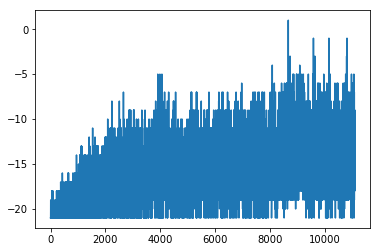

In [19]:
plt.plot(trainer.total_rewards)

In [20]:
writer_path

'runs/Jan08_15-07-08_amax'